# Analyzing the effect of noise on recovery rate

In [14]:
import os
from collections import defaultdict

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

LOGS_PATH = "../../logs"

sns.set_theme(style="ticks")
sns.set_style('whitegrid')

get_data = lambda path:  pd.read_excel(path,engine="openpyxl", usecols="B:H")

In [15]:
def get_exp_results_by_noise(pts:int=200):
    
    exp_data = defaultdict(dict)

    for dataset in os.listdir(LOGS_PATH):

        dataset_path = os.path.join(LOGS_PATH, dataset)
        model_results = defaultdict(dict)

        for model in sorted(os.listdir(dataset_path), key=lambda x: x.lower()):

            model_path = os.path.join(dataset_path, model)

            filter_fn = lambda x: (
                x[-4:] == "xlsx" and \
                int(x.split("_")[2].split("-")[1]) == pts
            )
            for file in filter(filter_fn, os.listdir(model_path)):
                header = file.split("_")
                model = header[0]
                noise = header[1].split("-")[1]
                
                if model_results[model].get(noise) is None:
                    tmp = get_data(os.path.join(model_path, file))
                    tmp["trial"] = [0]*len(tmp)
                    model_results[model][noise] = [tmp]
                    continue
                
                tmp = get_data(os.path.join(model_path, file))
                tmp["trial"] = [len(model_results[model][noise])]*len(tmp)
                
                model_results[model][noise].append(tmp)
                
        exp_data[dataset] = dict(model_results)
            
    return exp_data
            

exp_data = get_exp_results_by_noise()


In [16]:
dataset_df = {}

for dataset in os.listdir(LOGS_PATH):

    acc, tim = [], []

    df_dict = {
        "model":[],
        "accuracy":[],
        "noise":[],
        "duration":[],
        "trial":[],
    }    
    
    models = sorted(exp_data[dataset].keys())
    for model in models:
        
        noises = sorted(exp_data[dataset][model].keys(), key=lambda x: float(x))
        for noise in noises:
            
            for df_col in exp_data[dataset][model][noise]:
            
                acc = len(df_col[df_col["accuracy"]>=0.90])/len(df_col)        
                dur = df_col.describe()['time']['mean']
                trial = int(df_col.describe()['trial']['mean'])

                df_dict["model"].append(model)
                df_dict["accuracy"].append(acc)
                df_dict["noise"].append(noise)
                df_dict["duration"].append(dur)
                df_dict["trial"].append(trial)
            
    df = pd.DataFrame(data=df_dict)
    dataset_df[dataset] = df

In [17]:
dataset_df["nguyen-12"]

,model,accuracy,noise,duration,trial
0,AIF,0.583333,0.0,67.588193,0
1,AIF,0.666667,0.0,66.906632,1
2,AIF,0.583333,0.001,67.849993,0
3,AIF,0.583333,0.001,68.144812,1
4,AIF,0.166667,0.01,67.768185,0
5,AIF,0.166667,0.01,68.319921,1
6,AIF,0.000000,0.1,68.347129,0
7,AIF,0.000000,0.1,68.643677,1
8,NeSymRes,0.083333,0.0,25.577648,0
9,NeSymRes,0.166667,0.0,19.740848,1


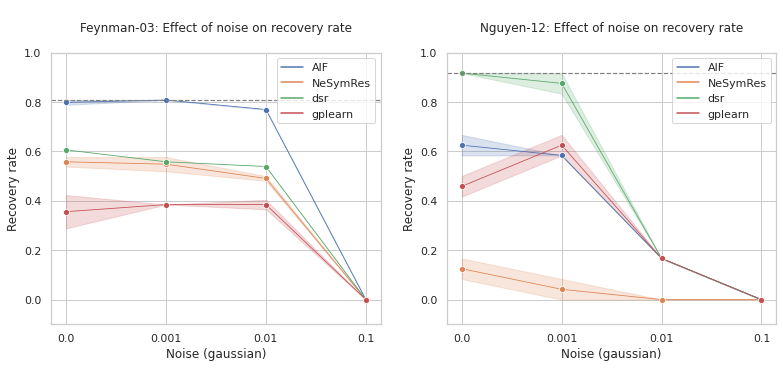

In [18]:
def show_acc_plot(datasets:list):
    
    f, axs = plt.subplots(1,len(datasets),
                      figsize=(13,5),
                      )
    
    for i, dataset in enumerate(datasets):
        
        fig = sns.lineplot(x="noise", y="accuracy",
            hue="model",
            data=dataset_df[dataset], marker="o", 
            linewidth = 0.8,  ax=axs[i]
        )

        fig.set_title(f"\n{dataset.capitalize()}: Effect of noise on recovery rate\n")
        fig.axhline(dataset_df[dataset]["accuracy"].max(), linestyle="--", linewidth=1.2, color='gray')
    
        fig.set_ylim(-0.1, 1.0)
    
        handles, labels = axs[i].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.set_xlabel("Noise (gaussian)")
        fig.set_ylabel("Recovery rate")

show_acc_plot(["Feynman-03", "nguyen-12"])

In [19]:
dataset_df["nguyen-12"].pivot_table(index="model", columns="noise", values=["accuracy"])

accuracy                         
noise          0.0     0.001      0.01  0.1
model                                      
AIF       0.625000  0.583333  0.166667  0.0
NeSymRes  0.125000  0.041667  0.000000  0.0
dsr       0.916667  0.875000  0.166667  0.0
gplearn   0.458333  0.625000  0.166667  0.0

In [20]:
dataset_df["Feynman-03"].pivot_table(index="model", columns="noise", values=["accuracy"])

accuracy                         
noise          0.0     0.001      0.01  0.1
model                                      
AIF       0.798077  0.807692  0.769231  0.0
NeSymRes  0.557692  0.548077  0.490385  0.0
dsr       0.605769  0.557692  0.538462  0.0
gplearn   0.355769  0.384615  0.384615  0.0

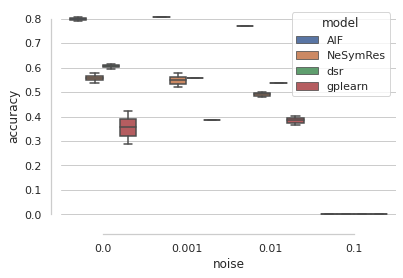

In [21]:
sns.boxplot(x="noise", y="accuracy",
            hue="model",
            data=dataset_df[dataset])
sns.despine(offset=10, trim=True)

In [ ]:
sns.bo

In [12]:
dataset_df["Feynman-03"]

,model,accuracy,noise,duration,trial
0,AIF,0.788462,0.0,66.177374,0
1,AIF,0.788462,0.0,66.177374,1
2,AIF,0.788462,0.0,66.669709,2
3,AIF,0.769231,0.001,67.302822,0
4,AIF,0.750000,0.001,67.810076,1
5,AIF,0.769231,0.001,67.302822,2
6,AIF,0.596154,0.01,67.697698,0
7,AIF,0.615385,0.01,68.100004,1
8,AIF,0.596154,0.01,67.697698,2
9,AIF,0.230769,0.1,68.715877,0
